# Testando os métodos de rebalanceamento

### Todos os pacotes que usaremos nesta segunda parte

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
import scikitplot as skplt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df.rename(columns={'id':'ID', 'gender': 'Gênero', 'age': 'Idade', 'hypertension':'Hipertensão', 'heart_disease':'Doença cardíaca',
                   'ever_married':'Já casou','work_type':'Tipo de trabalho','Residence_type':'Tipo de residência',
                   'avg_glucose_level':'Nível médio de glicose','bmi':'IMC','smoking_status':'Tabagismo','stroke':'Derrame'}, inplace=True)

In [4]:
df.head()

,ID,Gênero,Idade,Hipertensão,Doença cardíaca,Já casou,Tipo de trabalho,Tipo de residência,Nível médio de glicose,IMC,Tabagismo,Derrame
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df["Gênero"] = df["Gênero"].str.replace("Male","Masculino")
df["Gênero"] = df["Gênero"].str.replace("Female","Feminino")
df["Gênero"] = df["Gênero"].str.replace("Other","Outro")

In [6]:
df["Já casou"] = df["Já casou"].str.replace("Yes","Sim")
df["Já casou"] = df["Já casou"].str.replace("No","Não")

In [7]:
df["Tipo de trabalho"] = df["Tipo de trabalho"].str.replace("children","Criança")
df["Tipo de trabalho"] = df["Tipo de trabalho"].str.replace("Govt_job","Serv_publi")
df["Tipo de trabalho"] = df["Tipo de trabalho"].str.replace("Never_worked","Nunca_trab")
df["Tipo de trabalho"] = df["Tipo de trabalho"].str.replace("Private","Privado")
df["Tipo de trabalho"] = df["Tipo de trabalho"].str.replace("Self-employed","Autônomo")

In [8]:
df["Tipo de residência"] = df["Tipo de residência"].str.replace("Urban","Urbana")

In [9]:
df["Tabagismo"] = df["Tabagismo"].str.replace("formerly smoked","Já fumou")
df["Tabagismo"] = df["Tabagismo"].str.replace("never smoked","Nunca fumou")
df["Tabagismo"] = df["Tabagismo"].str.replace("smokes","Fuma")
df["Tabagismo"] = df["Tabagismo"].str.replace("Unknown","Desconhecido")

In [10]:
DT_IMC_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X1 = df[['Idade','Gênero','IMC','Nível médio de glicose']].copy()
X1['Gênero'] = X1['Gênero'].replace({'Masculino':0,'Feminino':1,'Outro':-1}).astype(np.uint8)

Missing = X1[X1['IMC'].isna()]
X1 = X1[~X1['IMC'].isna()]
Y1 = X1.pop('IMC')
DT_IMC_pipe.fit(X1,Y1)
#Usando vairáveis relacionadas com IMC para prevelo, 'Idade','Gênero','Nível médio de glicose'
predicted_IMC = pd.Series(DT_IMC_pipe.predict(Missing[['Idade','Gênero','Nível médio de glicose']]),index=Missing.index)
df.loc[Missing.index,'IMC'] = predicted_IMC

### Criando X, que terá as variáveis que utilizaremos, e y, que terá a variável preditora

In [11]:
X = df.drop(['ID','Derrame'],axis=1)
y = df['Derrame']

In [12]:
X.head()

,Gênero,Idade,Hipertensão,Doença cardíaca,Já casou,Tipo de trabalho,Tipo de residência,Nível médio de glicose,IMC,Tabagismo
0,Masculino,67.0,0,1,Sim,Privado,Urbana,228.69,36.6,Já fumou
1,Feminino,61.0,0,0,Sim,Autônomo,Rural,202.21,45.0,Nunca fumou
2,Masculino,80.0,0,1,Sim,Privado,Rural,105.92,32.5,Nunca fumou
3,Feminino,49.0,0,0,Sim,Privado,Urbana,171.23,34.4,Fuma
4,Feminino,79.0,1,0,Sim,Autônomo,Rural,174.12,24.0,Nunca fumou


### Usando o one hot encoding

In [13]:
X['Já casou'] = X['Já casou'].replace({'Não':0,'Sim':1}).astype(np.uint8)
X = pd.get_dummies(X, columns = ['Tipo de trabalho','Tabagismo','Gênero','Tipo de residência'])

In [14]:
X.head()

,Idade,Hipertensão,Doença cardíaca,Já casou,Nível médio de glicose,IMC,Tipo de trabalho_Autônomo,Tipo de trabalho_Criança,Tipo de trabalho_Nunca_trab,Tipo de trabalho_Privado,Tipo de trabalho_Serv_publi,Tabagismo_Desconhecido,Tabagismo_Fuma,Tabagismo_Já fumou,Tabagismo_Nunca fumou,Gênero_Feminino,Gênero_Masculino,Gênero_Outro,Tipo de residência_Rural,Tipo de residência_Urbana
0,67.0,0,1,1,228.69,36.6,0,0,0,1,0,0,0,1,0,0,1,0,0,1
1,61.0,0,0,1,202.21,45.0,1,0,0,0,0,0,0,0,1,1,0,0,1,0
2,80.0,0,1,1,105.92,32.5,0,0,0,1,0,0,0,0,1,0,1,0,1,0
3,49.0,0,0,1,171.23,34.4,0,0,0,1,0,0,1,0,0,1,0,0,0,1
4,79.0,1,0,1,174.12,24.0,1,0,0,0,0,0,0,0,1,1,0,0,1,0


### Criando o dataframe "base" para o K-fold

In [15]:
base = df.drop(['ID'],axis=1)
base['Já casou'] = base['Já casou'].replace({'Não':0,'Sim':1}).astype(np.uint8)
base = pd.get_dummies(base, columns = ['Tipo de trabalho','Tabagismo','Gênero','Tipo de residência'])

### Função para fazer o K-fold manualmente

In [16]:
def kfold(base, k = 10):
    '''Essa função retorna, de acordo com a base e o k, os indexes aleatórios para cada partição k.'''
    list_indexes = [] # Lista com os indexes para cada partição. 
    obs_in_each_partition = int(np.round(base.shape[0]/k)) # quantas observações em cada partição
    
    possible_indexes = base.index.values # lista de indexes da base possíveis
    for k_zin in range(1, k):
        new_list_index = np.random.choice(possible_indexes, obs_in_each_partition, replace = False) #escolhendo as obs para o k
        possible_indexes = set(possible_indexes) - set(new_list_index) #tirando as obs do k atual, da lista de indexes possíveis
        possible_indexes = list(possible_indexes) 
        list_indexes.append(new_list_index) # adicionando as obs do k atual, na lista com os indexes para cada partição.
    
    list_indexes.append(np.array(possible_indexes)) # adicionando as obs da última partição (normalmente com menor size)
    return list_indexes    

### Criando uma divisão entre treino e teste e os pipelines do modelos

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])

### Função para o plot do heatmap das medidas

In [18]:
def medidas(nome):
    fig = plt.figure(figsize=(16,4))
    gs = fig.add_gridspec(1, 2)
    gs.update(wspace=0.1, hspace=0.25)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    background_color = "#ffffff"
    fig.patch.set_facecolor(background_color)

    rf_scores = np.array([np.mean(performance_rf[:,0]),np.mean(performance_rf[:,1]),
                         np.mean(performance_rf[:,2]),np.mean(performance_rf[:,3])])

    scores_names = np.array(['Acurácia','Precisão',
                         'Recall','F1-score'])
    group_scores = ['{:.4f}'.format(value) for value in
                    rf_scores]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(scores_names,group_scores)]
    labels = np.asarray(labels).reshape(4,1)
    rf_scores = np.asarray(rf_scores).reshape(4,1)

    sns.heatmap(rf_scores, annot=labels, fmt='', cmap='Greys',ax=ax0,xticklabels=False,yticklabels=False,vmin=0, vmax=1)
    ax0.tick_params(left=False, bottom=False)
    ax0.set_title('Random Forest',loc='center', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

    logreg_scores = np.array([np.mean(performance_logreg[:,0]),np.mean(performance_logreg[:,1]),
                         np.mean(performance_logreg[:,2]),np.mean(performance_logreg[:,3])])

    group_scores = ['{:.4f}'.format(value) for value in
                    logreg_scores]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(scores_names,group_scores)]
    labels = np.asarray(labels).reshape(4,1)
    logreg_scores = np.asarray(logreg_scores).reshape(4,1)

    sns.heatmap(logreg_scores, annot=labels, fmt='', cmap='Greys',ax=ax1,xticklabels=False,yticklabels=False,vmin=0, vmax=1)
    ax1.tick_params(left=False, bottom=False)
    ax1.set_title('Regressão Logística',loc='center', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
    fig.suptitle(nome, fontsize=16, fontweight='bold', fontfamily='serif', color="#323232")
    
    plt.show()

### Função para o plot do heatmap da matriz de confusão

In [19]:
def matriz_confusao(nome):    
    fig = plt.figure(figsize=(16,8))
    gs = fig.add_gridspec(1, 2)
    gs.update(wspace=0.15, hspace=0.15)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    background_color = "#ffffff"
    fig.patch.set_facecolor(background_color)

    group_names = ['Verdadeiro negativo','Falso positivo','Falso negativo','Verdadeiro positivo']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    np.round(cm_rf).flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         np.round(cm_rf).flatten()/np.sum(np.round(cm_rf))]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(np.round(cm_rf), annot=labels, fmt='', cmap='Greys',ax=ax0)

    group_names = ['Verdadeiro negativo','Falso positivo','Falso negativo','Verdadeiro positivo']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    np.round(cm_rl).flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         np.round(cm_rl).flatten()/np.sum(np.round(cm_rl))]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(np.round(cm_rl), annot=labels, fmt='', cmap='Greys',ax=ax1)

    ax0.set_title('Random Forest',loc='center', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
    ax1.set_title('Regressão Logística',loc='center', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
    fig.suptitle(nome, fontsize=16, fontweight='bold', fontfamily='serif', color="#323232")

    plt.show()

## Analisando o desempenho dos métodos de rebalanceamento

In [20]:
import warnings
warnings.filterwarnings('ignore')

### Caso desbalanceado

#### Utilizando o K-fold para obter métricas com menor variância

In [21]:
performance_rf = np.zeros((10,4))
performance_logreg = np.zeros((10,4))
cm_rf = np.zeros((2,2))
cm_rl = np.zeros((2,2))
c = -1
for k in kfold(base):
    # dividindo a base
    base_val = base.iloc[k]
    indexes_train = base.index.difference(base_val.index)
    base_treino = base.iloc[indexes_train] 
    
    # dividindo em X e y
    X_train, y_train = base_treino.drop(['Derrame'], 1), base_treino.Derrame
    X_val, y_val = base_val.drop(['Derrame'], 1), base_val.Derrame
    
    # fazendo o modelo
    model_rf = rf_pipeline.fit(X_train, y_train)
    model_logreg = logreg_pipeline.fit(X_train, y_train)
    
    # predizendo na base de validação normalizada
    y_pred_rf = model_rf.predict(X_val)
    y_pred_logreg = model_logreg.predict(X_val)
    
    # alocando o f1_score do k atual, na lista de perforamnce
    c = c + 1 
    cm_rf = cm_rf + confusion_matrix(y_val, y_pred_rf)
    cm_rl = cm_rl + confusion_matrix(y_val, y_pred_logreg)
    performance_rf[c,0:9] = np.array([accuracy_score(y_val, y_pred_rf),precision_score(y_val, y_pred_rf),
                     recall_score(y_val, y_pred_rf),f1_score(y_val, y_pred_rf)])
    performance_logreg[c,0:9] = np.array([accuracy_score(y_val, y_pred_logreg),precision_score(y_val, y_pred_logreg),
                     recall_score(y_val, y_pred_logreg),f1_score(y_val, y_pred_logreg)])

cm_rf = cm_rf/10
cm_rl = cm_rl/10
print('Random Forest:')
print(f'{np.round(np.mean(performance_rf[:,0]),4)} é a acurácia média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,1]),4)} é a precisão média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,2]),4)} é o recall médio da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,3]),4)} é o f1-score média da validação k-fold, com k igual a 10.')
print(f'{np.round(cm_rf)} é a matriz de confusão média da validação k-fold, com k igual a 10.')

print('Regressão Logística:')
print(f'{np.round(np.mean(performance_logreg[:,0]),4)} é a acurácia média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,1]),4)} é a precisão média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,2]),4)} é o recall médio da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,3]),4)} é o f1-score média da validação k-fold, com k igual a 10.')
print(f'{np.round(cm_rl)} é a matriz de confusão média da validação k-fold, com k igual a 10.')


Random Forest:
0.9491 é a acurácia média da validação k-fold, com k igual a 10.
0.1 é a precisão média da validação k-fold, com k igual a 10.
0.0036 é o recall médio da validação k-fold, com k igual a 10.
0.0069 é o f1-score média da validação k-fold, com k igual a 10.
[[485.   1.]
 [ 25.   0.]] é a matriz de confusão média da validação k-fold, com k igual a 10.
Regressão Logística:
0.9515 é a acurácia média da validação k-fold, com k igual a 10.
0.1 é a precisão média da validação k-fold, com k igual a 10.
0.0036 é o recall médio da validação k-fold, com k igual a 10.
0.0069 é o f1-score média da validação k-fold, com k igual a 10.
[[486.   0.]
 [ 25.   0.]] é a matriz de confusão média da validação k-fold, com k igual a 10.


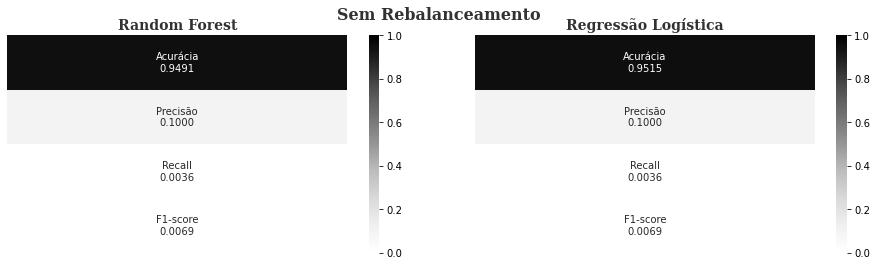

In [22]:
medidas('Sem Rebalanceamento')

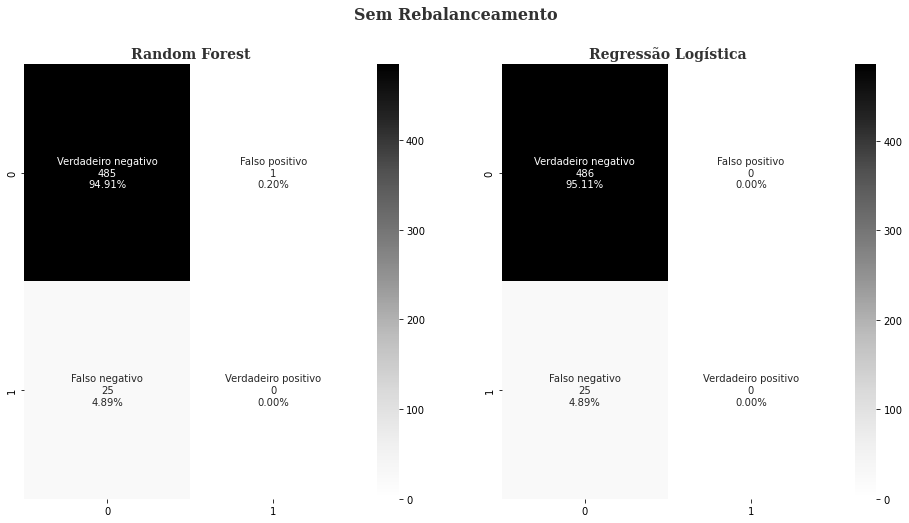

In [23]:
matriz_confusao('Sem Rebalanceamento')

### Oversampling sem rebalancear os dados de validação

#### Utilizando o K-fold para obter métricas com menor variância

In [24]:
ros = RandomOverSampler(random_state=42)

performance_rf = np.zeros((10,4))
performance_logreg = np.zeros((10,4))
cm_rf = np.zeros((2,2))
cm_rl = np.zeros((2,2))
c = -1
for k in kfold(base):
    # dividindo a base
    base_val = base.iloc[k]
    indexes_train = base.index.difference(base_val.index)
    base_treino = base.iloc[indexes_train] 
    
    # dividindo em X e y
    X_train, y_train = base_treino.drop(['Derrame'], 1), base_treino.Derrame
    X_train, y_train = ros.fit_resample(X_train, y_train)
    X_val, y_val = base_val.drop(['Derrame'], 1), base_val.Derrame
    
    # fazendo o modelo
    model_rf = rf_pipeline.fit(X_train, y_train)
    model_logreg = logreg_pipeline.fit(X_train, y_train)
    
    # predizendo na base de validação normalizada
    y_pred_rf = model_rf.predict(X_val)
    y_pred_logreg = model_logreg.predict(X_val)
    
    # alocando o f1_score do k atual, na lista de perforamnce
    c = c + 1 
    cm_rf = cm_rf + confusion_matrix(y_val, y_pred_rf)
    cm_rl = cm_rl + confusion_matrix(y_val, y_pred_logreg)
    performance_rf[c,0:9] = np.array([accuracy_score(y_val, y_pred_rf),precision_score(y_val, y_pred_rf),
                     recall_score(y_val, y_pred_rf),f1_score(y_val, y_pred_rf)])
    performance_logreg[c,0:9] = np.array([accuracy_score(y_val, y_pred_logreg),precision_score(y_val, y_pred_logreg),
                     recall_score(y_val, y_pred_logreg),f1_score(y_val, y_pred_logreg)])

cm_rf = cm_rf/10
cm_rl = cm_rl/10
print('Random Forest:')
print(f'{np.round(np.mean(performance_rf[:,0]),4)} é a acurácia média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,1]),4)} é a precisão média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,2]),4)} é o recall médio da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,3]),4)} é o f1-score média da validação k-fold, com k igual a 10.')
print(f'{np.round(cm_rf)} é a matriz de confusão média da validação k-fold, com k igual a 10.')

print('Regressão Logística:')
print(f'{np.round(np.mean(performance_logreg[:,0]),4)} é a acurácia média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,1]),4)} é a precisão média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,2]),4)} é o recall médio da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,3]),4)} é o f1-score média da validação k-fold, com k igual a 10.')
print(f'{np.round(cm_rl)} é a matriz de confusão média da validação k-fold, com k igual a 10.')

Random Forest:
0.9397 é a acurácia média da validação k-fold, com k igual a 10.
0.0616 é a precisão média da validação k-fold, com k igual a 10.
0.016 é o recall médio da validação k-fold, com k igual a 10.
0.0251 é o f1-score média da validação k-fold, com k igual a 10.
[[480.   6.]
 [ 24.   0.]] é a matriz de confusão média da validação k-fold, com k igual a 10.
Regressão Logística:
0.7407 é a acurácia média da validação k-fold, com k igual a 10.
0.1331 é a precisão média da validação k-fold, com k igual a 10.
0.786 é o recall médio da validação k-fold, com k igual a 10.
0.2271 é o f1-score média da validação k-fold, com k igual a 10.
[[359. 127.]
 [  5.  20.]] é a matriz de confusão média da validação k-fold, com k igual a 10.


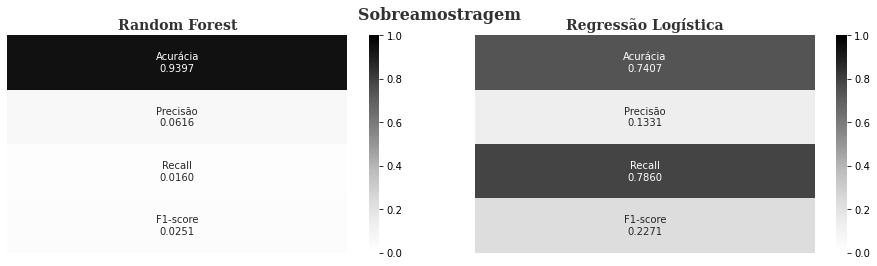

In [25]:
medidas('Sobreamostragem')

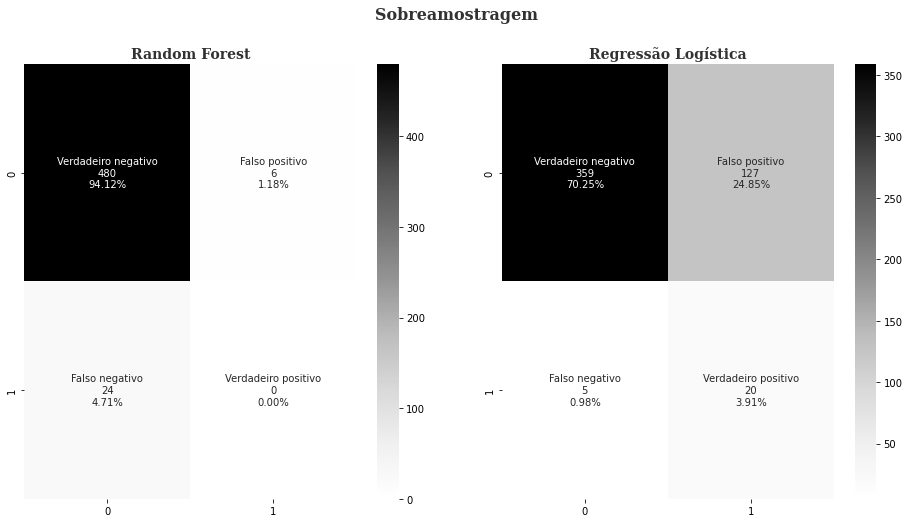

In [26]:
matriz_confusao('Sobreamostragem')

### Undersampling sem rebalancear os dados de validação

#### Utilizando o K-fold para obter métricas com menor variância

In [27]:
rus = RandomUnderSampler(random_state=42)

performance_rf = np.zeros((10,4))
performance_logreg = np.zeros((10,4))
cm_rf = np.zeros((2,2))
cm_rl = np.zeros((2,2))
c = -1
for k in kfold(base):
    # dividindo a base
    base_val = base.iloc[k]
    indexes_train = base.index.difference(base_val.index)
    base_treino = base.iloc[indexes_train] 
    
    # dividindo em X e y
    X_train, y_train = base_treino.drop(['Derrame'], 1), base_treino.Derrame
    X_train, y_train = rus.fit_resample(X_train, y_train)
    X_val, y_val = base_val.drop(['Derrame'], 1), base_val.Derrame
    
    # fazendo o modelo
    model_rf = rf_pipeline.fit(X_train, y_train)
    model_logreg = logreg_pipeline.fit(X_train, y_train)
    
    # predizendo na base de validação normalizada
    y_pred_rf = model_rf.predict(X_val)
    y_pred_logreg = model_logreg.predict(X_val)
    
    # alocando o f1_score do k atual, na lista de perforamnce
    c = c + 1 
    cm_rf = cm_rf + confusion_matrix(y_val, y_pred_rf)
    cm_rl = cm_rl + confusion_matrix(y_val, y_pred_logreg)
    performance_rf[c,0:9] = np.array([accuracy_score(y_val, y_pred_rf),precision_score(y_val, y_pred_rf),
                     recall_score(y_val, y_pred_rf),f1_score(y_val, y_pred_rf)])
    performance_logreg[c,0:9] = np.array([accuracy_score(y_val, y_pred_logreg),precision_score(y_val, y_pred_logreg),
                     recall_score(y_val, y_pred_logreg),f1_score(y_val, y_pred_logreg)])

cm_rf = cm_rf/10
cm_rl = cm_rl/10
print('Random Forest:')
print(f'{np.round(np.mean(performance_rf[:,0]),4)} é a acurácia média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,1]),4)} é a precisão média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,2]),4)} é o recall médio da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,3]),4)} é o f1-score média da validação k-fold, com k igual a 10.')
print(f'{np.round(cm_rf)} é a matriz de confusão média da validação k-fold, com k igual a 10.')

print('Regressão Logística:')
print(f'{np.round(np.mean(performance_logreg[:,0]),4)} é a acurácia média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,1]),4)} é a precisão média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,2]),4)} é o recall médio da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,3]),4)} é o f1-score média da validação k-fold, com k igual a 10.')
print(f'{np.round(cm_rl)} é a matriz de confusão média da validação k-fold, com k igual a 10.')

Random Forest:
0.7082 é a acurácia média da validação k-fold, com k igual a 10.
0.1159 é a precisão média da validação k-fold, com k igual a 10.
0.7512 é o recall médio da validação k-fold, com k igual a 10.
0.2004 é o f1-score média da validação k-fold, com k igual a 10.
[[343. 143.]
 [  6.  19.]] é a matriz de confusão média da validação k-fold, com k igual a 10.
Regressão Logística:
0.7335 é a acurácia média da validação k-fold, com k igual a 10.
0.1285 é a precisão média da validação k-fold, com k igual a 10.
0.7712 é o recall médio da validação k-fold, com k igual a 10.
0.2199 é o f1-score média da validação k-fold, com k igual a 10.
[[356. 131.]
 [  6.  19.]] é a matriz de confusão média da validação k-fold, com k igual a 10.


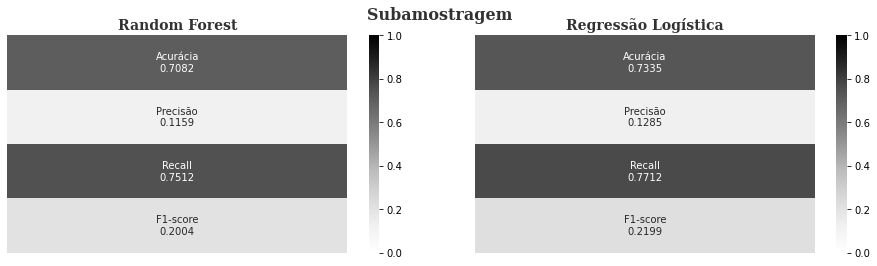

In [28]:
medidas('Subamostragem')

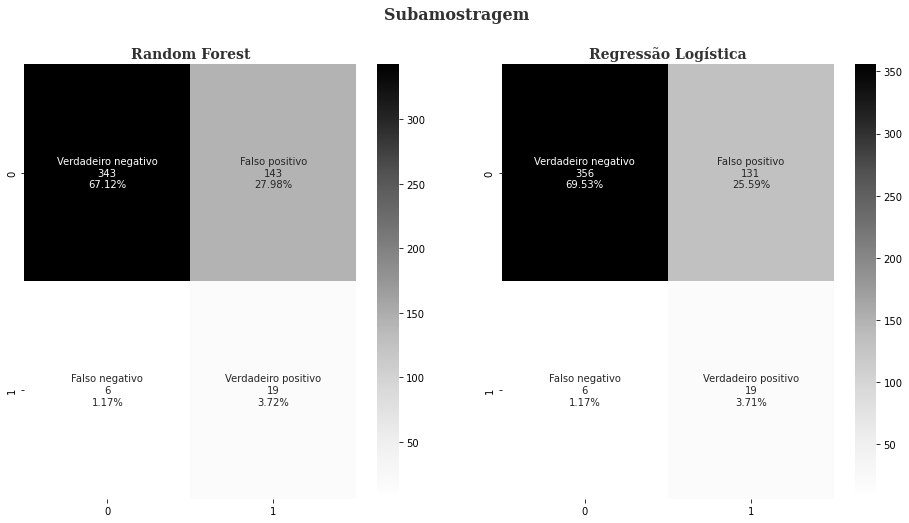

In [29]:
matriz_confusao('Subamostragem')

### SMOTE sem rebalancear os dados de validação

#### Utilizando o K-fold para obter métricas com menor variância

In [30]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

performance_rf = np.zeros((10,4))
performance_logreg = np.zeros((10,4))
cm_rf = np.zeros((2,2))
cm_rl = np.zeros((2,2))
c = -1
for k in kfold(base):
    '''O que estamos fazendo no looping: 
       Para cada partição k retornada da função kfold(...) nós fazemos o workflow de modelagem, 
       sendo ele; Dividir a base em treino e teste, 
                  dividir essas bases em X e y (para uso nas funções do sklearn),
                  criando o modelo (ainda normalizando as features, como visto no exercício 1),
                  predizendo nos dados não vistos &
                  alocando a métrica f1_score na lista de métricas.
        '''
    # dividindo a base
    base_val = base.iloc[k]
    indexes_train = base.index.difference(base_val.index)
    base_treino = base.iloc[indexes_train] 
    
    # dividindo em X e y
    X_train, y_train = base_treino.drop(['Derrame'], 1), base_treino.Derrame
    X_train, y_train = sm.fit_resample(X_train, y_train)
    X_val, y_val = base_val.drop(['Derrame'], 1), base_val.Derrame
    
    # fazendo o modelo
    model_rf = rf_pipeline.fit(X_train, y_train)
    model_logreg = logreg_pipeline.fit(X_train, y_train)
    
    # predizendo na base de validação normalizada
    y_pred_rf = model_rf.predict(X_val)
    y_pred_logreg = model_logreg.predict(X_val)
    
    # alocando o f1_score do k atual, na lista de perforamnce
    c = c + 1 
    cm_rf = cm_rf + confusion_matrix(y_val, y_pred_rf)
    cm_rl = cm_rl + confusion_matrix(y_val, y_pred_logreg)
    performance_rf[c,0:9] = np.array([accuracy_score(y_val, y_pred_rf),precision_score(y_val, y_pred_rf),
                     recall_score(y_val, y_pred_rf),f1_score(y_val, y_pred_rf)])
    performance_logreg[c,0:9] = np.array([accuracy_score(y_val, y_pred_logreg),precision_score(y_val, y_pred_logreg),
                     recall_score(y_val, y_pred_logreg),f1_score(y_val, y_pred_logreg)])

cm_rf = cm_rf/10
cm_rl = cm_rl/10
print('Random Forest:')
print(f'{np.round(np.mean(performance_rf[:,0]),4)} é a acurácia média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,1]),4)} é a precisão média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,2]),4)} é o recall médio da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_rf[:,3]),4)} é o f1-score média da validação k-fold, com k igual a 10.')
print(f'{np.round(cm_rf)} é a matriz de confusão média da validação k-fold, com k igual a 10.')

print('Regressão Logística:')
print(f'{np.round(np.mean(performance_logreg[:,0]),4)} é a acurácia média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,1]),4)} é a precisão média da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,2]),4)} é o recall médio da validação k-fold, com k igual a 10.')
print(f'{np.round(np.mean(performance_logreg[:,3]),4)} é o f1-score média da validação k-fold, com k igual a 10.')
print(f'{np.round(cm_rl)} é a matriz de confusão média da validação k-fold, com k igual a 10.')

Random Forest:
0.9421 é a acurácia média da validação k-fold, com k igual a 10.
0.0725 é a precisão média da validação k-fold, com k igual a 10.
0.0194 é o recall médio da validação k-fold, com k igual a 10.
0.0303 é o f1-score média da validação k-fold, com k igual a 10.
[[481.   5.]
 [ 24.   0.]] é a matriz de confusão média da validação k-fold, com k igual a 10.
Regressão Logística:
0.9485 é a acurácia média da validação k-fold, com k igual a 10.
0.3556 é a precisão média da validação k-fold, com k igual a 10.
0.0426 é o recall médio da validação k-fold, com k igual a 10.
0.0725 é o f1-score média da validação k-fold, com k igual a 10.
[[484.   2.]
 [ 24.   1.]] é a matriz de confusão média da validação k-fold, com k igual a 10.


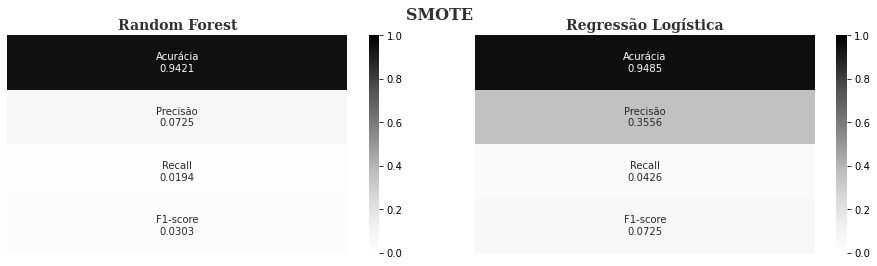

In [31]:
medidas('SMOTE')

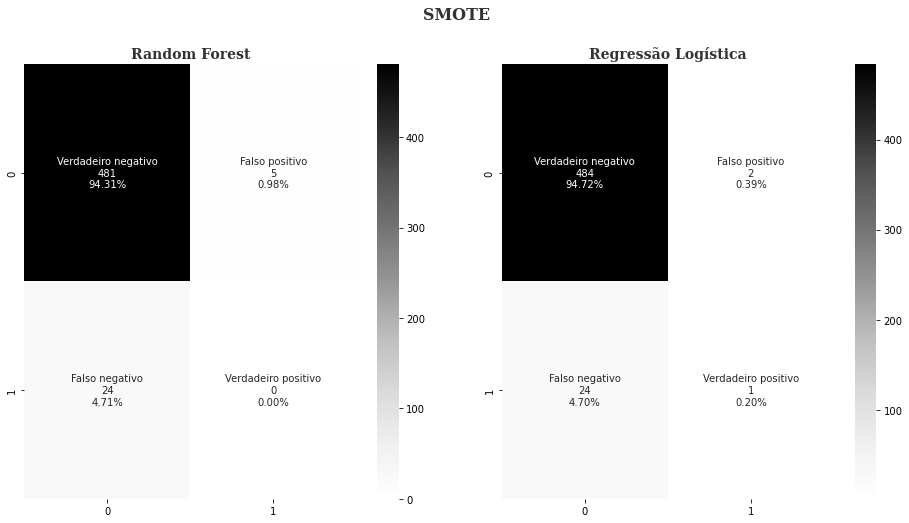

In [32]:
matriz_confusao('SMOTE')